In [1]:
%matplotlib notebook

import sys
import os
import time

In [2]:
paths = ['d:/code/broadbean', 'd:/code/labtools', 'd:/code/v2_dataset_tools']
for p in paths:
    if p not in sys.path:
        sys.path.append(p)

In [3]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter

from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [4]:
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

# Init

## load instruments

In [5]:
%run init_cQED.py

Connected to: TEKTRONIX AWG5014C (serial:B051389, firmware:SCPI:99.0 FW:4.6.0.7) in 0.16s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110509, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110510, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.04s


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

## Default settings

In [6]:
ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)

# CW spec

## AWG sequence (to trigger Alazar)

In [ ]:
ramp = bb.PulseAtoms.ramp

SR = 1e9
initial_delay = 1e-6
alz_trigger_len = 100e-9
alz_buf = 1e-6
rep_rate = 100e-6

spec_elem = bb.Element()

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=rep_rate, name='ro_segment')
readout.setSegmentMarker('ro_segment', (initial_delay, alz_trigger_len), 1)
readout.setSegmentMarker('ro_segment', (initial_delay + alz_buf, rep_rate - initial_delay - 2*alz_buf), 2)

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=rep_rate, name='spec_segment')
qubit.setSegmentMarker('spec_segment', (initial_delay + alz_buf, rep_rate - initial_delay - 2*alz_buf), 1)


spec_elem.addBluePrint(1, readout)
spec_elem.addBluePrint(2, qubit)

seq = bb.Sequence()
seq.name = 'spec'

seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)
seq.setChannelAmplitude(2, 1)
seq.setChannelOffset(2, 0)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

# plotter(seq)

In [ ]:
awg5014.stop()
awg5014.clock_freq(SR)
pkg = seq.outputForAWGFile()
awg5014.make_send_and_load_awg_file(*pkg[:])
awg5014.ch1_state(1)
awg5014.ch2_state(1)
awg5014.start()

## Test Alazar signal

In [ ]:
rel_acq.acq_time = 98e-6
rel_acq.demod_frq = 20e6
rel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=100,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = rel_acq.do_acquisition()
avg_data = np.squeeze(data).mean(axis=0) # .mean(axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(rel_acq.demod_tvals * 1e6, avg_data.real, label='Re')
ax.plot(rel_acq.demod_tvals * 1e6, avg_data.imag, label='Im')
ax.plot(rel_acq.demod_tvals * 1e6, np.abs(avg_data), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

## RO spec

<IPython.core.display.Javascript object>


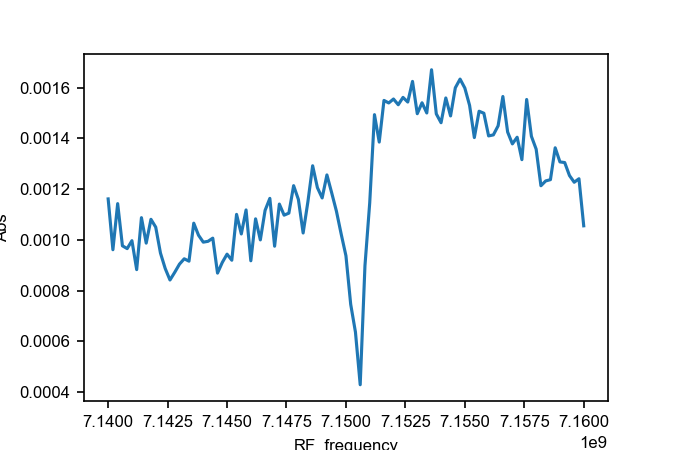

Starting experimental run with id: 87
Completed measurement. Database path: ref-transmon/resonator-spec/52


In [32]:
@getter([('I', ''), ('Q', ''), ('Abs', '')])
def measure_IQ():
    data = iq_acq.do_acquisition()
#     data = rel_acq.do_acquisition()
    data = data.mean()
    result = data.real.astype(float), data.imag.astype(float), np.abs(data).astype(float)
    return result

iq_acq.acq_time = 98e-6
iq_acq.demod_frq = 20e6
iq_acq.update_acquisitionkwargs(records_per_buffer=500, 
                                buffers_per_acquisition=1,
                                buffer_timeout=10000,
                                allocated_buffers=1)

# rel_acq.acq_time = 98e-6
# rel_acq.demod_frq = 20e6
# rel_acq.update_acquisitionkwargs(records_per_buffer=1, 
#                                  buffers_per_acquisition=1000,
#                                  buffer_timeout=10000,
#                                  allocated_buffers=1)


frqs = np.linspace(7.14e9, 7.16e9, 101)

setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/resonator-spec",
    setup,
    nest(
        szip(
            sweep(LO.frequency, frqs + 20e6),
            sweep(RF.frequency, frqs),
        ),
        measure_IQ,
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
    live_plot_axes=[{'RF_frequency': 1, 'Abs' : 4},]
)

<IPython.core.display.Javascript object>


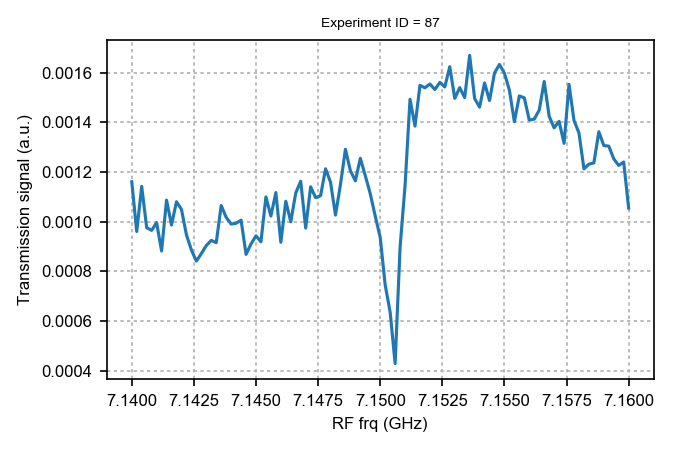

In [33]:
# ds = qc.load_by_id(85) #  
ds = result[1]
f = np.array(ds.get_values('RF_frequency')) * 1e-9 - 0.02 
sig = np.array(ds.get_values('Abs'))

fig, ax = plt.subplots()
ax.plot(f, sig, '-')

ax.set_xlabel('RF frq (GHz)')
ax.set_ylabel('Transmission signal (a.u.)')
ax.grid(dashes=[2,2])
ax.set_title('Experiment ID = {}'.format(ds.run_id), size='small')

fig.tight_layout()

## Qubit spec

<IPython.core.display.Javascript object>


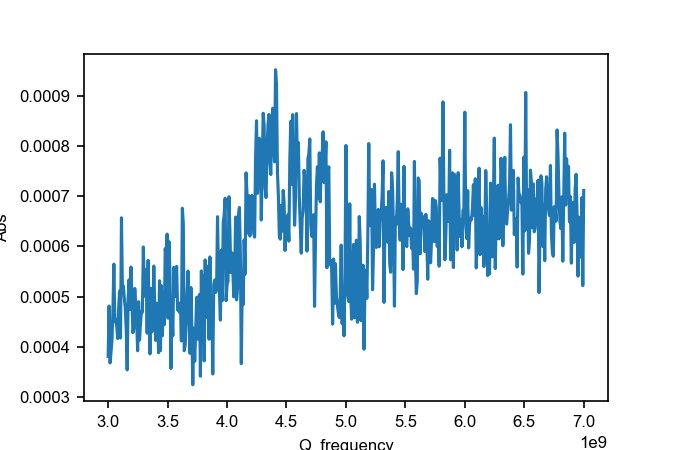

Starting experimental run with id: 88
Completed measurement. Database path: ref-transmon/QL-spec/27


In [34]:
iq_acq.acq_time = 98e-6
iq_acq.demod_frq = 20e6
iq_acq.update_acquisitionkwargs(records_per_buffer=500, 
                                buffers_per_acquisition=1,
                                buffer_timeout=10000,
                                allocated_buffers=1)


frqs = np.linspace(3e9, 6e9, 301)

setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/QL-spec",
    setup,
    nest(
        sweep(qubit_gen.frequency, frqs),
        measure_IQ
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
    live_plot_axes=[{'Q_frequency': 0, 'Abs' : 3},]
)

<IPython.core.display.Javascript object>


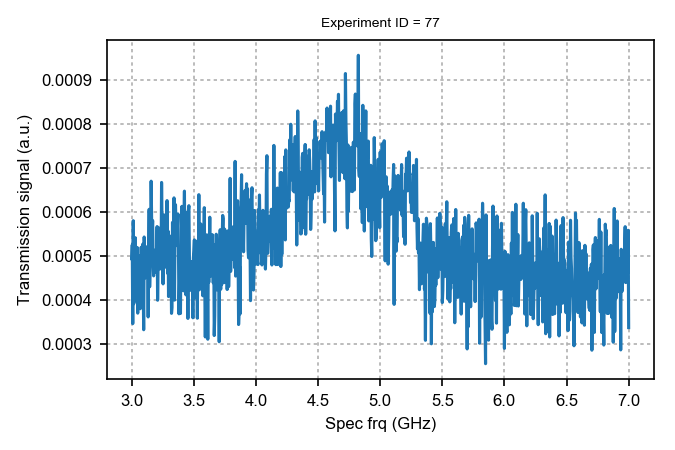

In [18]:
ds = result[1]
# ds = qc.load_by_id(43)
f = np.array(ds.get_values('qubit_gen_frequency')) * 1e-9
absvals = np.array(ds.get_values('Abs'))
ivals = np.array(ds.get_values('I'))
qvals = np.array(ds.get_values('Q'))

fig, ax = plt.subplots()
# ax.plot(f, ivals, '-')
# ax.plot(f, qvals, '-')
ax.plot(f, absvals, '-')

ax.set_xlabel('Spec frq (GHz)')
ax.set_ylabel('Transmission signal (a.u.)')
ax.grid(dashes=[2,2])
ax.set_title('Experiment ID = {}'.format(ds.run_id), size='small')

fig.tight_layout()

In [39]:
iq_acq.acq_time = 98e-6
iq_acq.demod_frq = 20e6
iq_acq.update_acquisitionkwargs(records_per_buffer=1000, 
                                buffers_per_acquisition=1,
                                buffer_timeout=10000,
                                allocated_buffers=1)


voltages = np.linspace(-1, 1, 51)
q_frqs = np.linspace(3.5e9, 5.5e9, 501)
r_frqs = np.linspace(7.1475e9, 7.1525e9, 51)

setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

result = do_experiment(
    "ref-transmon/flux_spec",
    setup,
    nest(
        sweep(awg5014.ch2_offset, voltages),
#         sweep(qubit_gen.frequency, frequencies),
        szip(
            sweep(LO.frequency, r_frqs + 20e6),
            sweep(RF.frequency, r_frqs),
        ),
        measure_IQ,
    ),
    cleanup,
    return_format=["data_set_path", "dataset"],
#     live_plot_axes=[{'Flux bias voltage': 0, 'Abs' : 3},]
)

Starting experimental run with id: 91
Completed measurement. Database path: ref-transmon/flux_spec/2


In [37]:
ds = qc.load_by_id(89)